In [8]:
!pip install nilearn
!pip install nibabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 17.3 MB/s eta 0:00:00


In [9]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

In [10]:
import os
os.environ['KAGGLE_USERNAME'] = "krinalbenmonpara" ## change your own username here.
os.environ['KAGGLE_KEY'] = "325691c14916fb32a33ea1e311767a6a"  ## change your own key.
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

brats20-dataset-training-validation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!unzip -q /content/brats20-dataset-training-validation.zip

In [11]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE',
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# days start interval
SURVIVAL_CATEGORIES= {
    'SHORT' : 0 , # 0-300
    'MEDIUM' : 300,  # 300-450
    'LONG' : 450, # 450 and more
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128
TRAIN_DATASET_PATH='/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

In [12]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
# file BraTS20_Training_355 has wrongly formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

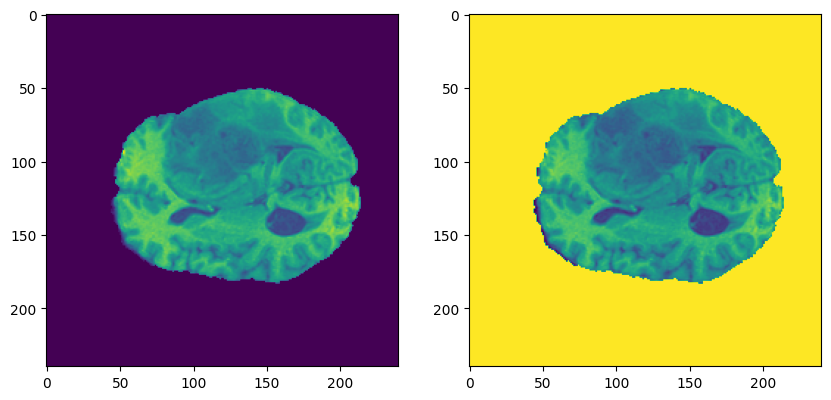

In [13]:
my_loc_slice=73
image_volume=nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
my_img=image_volume[:,:,my_loc_slice]
my_converted_img = my_img.copy()
my_converted_img[my_converted_img == 0] = 666

f, axarr = plt.subplots(1,2, figsize = (10, 5))
axarr[0].imshow(my_img)
axarr[1].imshow(my_converted_img)

In [14]:
def maskSizeForSlice(path,i_slice):
    totals = dict([(1, 0), (2, 0), (3, 0)])
    image_volume=nib.load(path).get_fdata()
    # flatten 3D image into 1D array and convert mask 4 to 2
    arr=image_volume[:,:,i_slice].flatten()
    arr[arr == 4] = 3

    unique, counts = np.unique(arr, return_counts=True)
    unique = unique.astype(int)
    values_dict=dict(zip(unique, counts))
    for k in range(1,4):
        totals[k] += values_dict.get(k,0)
    return totals

count class 1: 287
{1: 287, 2: 3843, 3: 631}


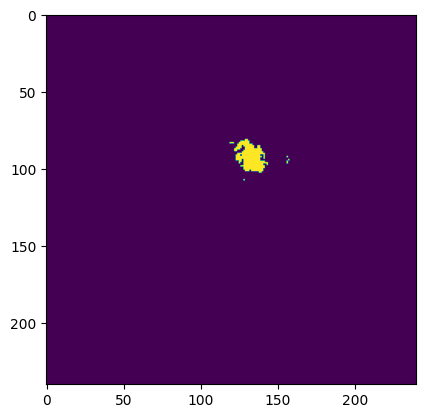

In [15]:
my_loc_slice=73
my_loc_class=1
seg_sum=maskSizeForSlice(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_seg.nii',my_loc_slice)


image_volume=nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()
image_loc=image_volume[:,:,my_loc_slice]
image_loc[image_loc != my_loc_class] = 0

# plot segment only for class 'my_loc_class'
plt.imshow(image_loc)

image_loc=image_loc.flatten()
count = np.count_nonzero(image_loc == my_loc_class)
print(f'count class {my_loc_class}: {count}')
print(seg_sum)

In [16]:
import csv

csv_path = '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv'

age_dict = {}
days_dict = {}


with open(csv_path, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file,delimiter = ',')
  #  row_count = sum(1 for row in csv_reader)
 #   print(f'total rows: {row_count} .')
    at_line = 0
    category_short = 0
    category_medium = 0
    category_long = 0
    max_days = 0
    for row in csv_reader:
        if at_line == 0:
            print(f'Column names are {", ".join(row)}')
            at_line += 1
        else:
            if (row[3] != "GTR"):
                continue
            print(row)
            key = row[0]
            age = row[1]
            days = row[2]
            if (not days.isnumeric()):
                continue
            age_dict[key] = float(age)
            days_dict[key] = int(days)
            max_days = max(max_days,int(days))
            if int(days) < 250:
                category_short += 1
            elif (int(days) >= 250 and int(days) <= 450):
                category_medium += 1
            else:
                category_long += 1
            at_line+=1

    print(f'Processed {at_line} lines.')
    print(category_short,category_medium,category_long)
    print(max_days)

Column names are Brats20ID, Age, Survival_days, Extent_of_Resection
['BraTS20_Training_001', '60.463', '289', 'GTR']
['BraTS20_Training_002', '52.263', '616', 'GTR']
['BraTS20_Training_003', '54.301', '464', 'GTR']
['BraTS20_Training_004', '39.068', '788', 'GTR']
['BraTS20_Training_005', '68.493', '465', 'GTR']
['BraTS20_Training_006', '67.126', '269', 'GTR']
['BraTS20_Training_007', '69.912', '503', 'GTR']
['BraTS20_Training_009', '56.419', '1155', 'GTR']
['BraTS20_Training_010', '48.367', '515', 'GTR']
['BraTS20_Training_012', '65.899', '495', 'GTR']
['BraTS20_Training_013', '59.693', '698', 'GTR']
['BraTS20_Training_014', '51.734', '359', 'GTR']
['BraTS20_Training_015', '62.614', '169', 'GTR']
['BraTS20_Training_016', '55.759', '368', 'GTR']
['BraTS20_Training_017', '58.258', '439', 'GTR']
['BraTS20_Training_018', '61.605', '486', 'GTR']
['BraTS20_Training_019', '68.049', '287', 'GTR']
['BraTS20_Training_021', '56.921', '576', 'GTR']
['BraTS20_Training_022', '44.162', '350', 'GTR']


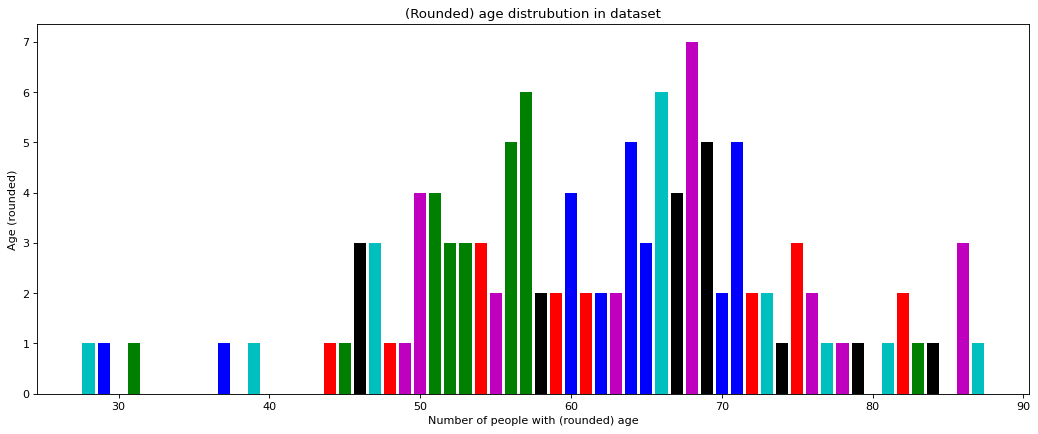

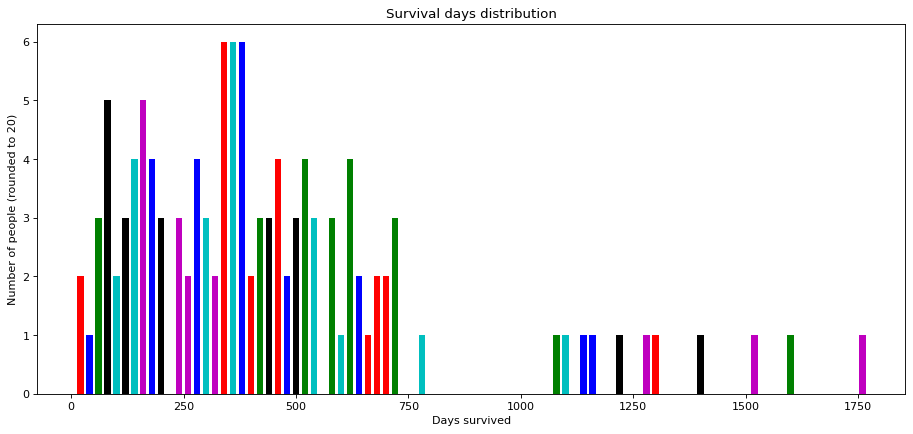

In [17]:
from collections import Counter
from itertools import cycle
#age_dict, days_dict

# round values in dictionary
age_dict_rounded = {key : round(age_dict[key], 0) for key in age_dict}
# survival days are very distinct values => move the values in ranges per 20
days_dict_rounded = {key : round(days_dict[key]/20)*20 for key in days_dict}

# count same numbers => create statistics how many times is there person with same age
age_dict_rounded_counted = Counter(age_dict_rounded.values())
days_dict_rounded_counted = Counter(days_dict_rounded.values())

cycol = cycle('bgrcmk')
colors = list()
for i in range(len(age_dict_rounded_counted)):
    colors.append(next(cycol))

cycol = cycle('bgrcmk')
colorsDays = list()
for i in range(len(days_dict_rounded_counted)):
    colorsDays.append(next(cycol))

plt.figure(figsize=(16, 6), dpi=80)
plt.xlabel('Number of people with (rounded) age')
plt.ylabel('Age (rounded)')
plt.title("(Rounded) age distrubution in dataset")
plt.bar(list(age_dict_rounded_counted.keys()), age_dict_rounded_counted.values(), color=colors)
plt.show()

plt.figure(figsize=(14, 6), dpi=80)
plt.xlabel('Days survived')
plt.ylabel('Number of people (rounded to 20)')
plt.title("Survival days distribution")
plt.bar(list(days_dict_rounded_counted.keys()), days_dict_rounded_counted.values(),width=15, color=colorsDays)
plt.show()

In [18]:
# get number of pixels for each segment as dictionary
# original images contain segment values (0,1,2,4) => 4 is our 3 ... :)
def getMaskSizesForVolume(image_volume):
    totals = dict([(1, 0), (2, 0), (3, 0)])
    for i in range(VOLUME_SLICES):
        # flatten 2D image into 1D array and convert mask 4 to 2
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        arr[arr == 4] = 3

        unique, counts = np.unique(arr, return_counts=True)
        unique = unique.astype(int)
        values_dict=dict(zip(unique, counts))
        for k in range(1,4):
            totals[k] += values_dict.get(k,0)
    return totals

total count: 1264556


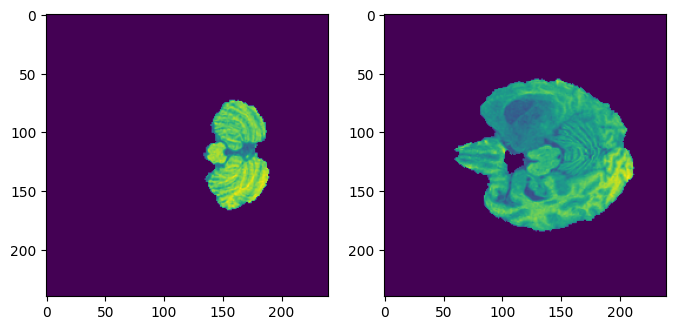

In [19]:
# returns count of non zero elements in whole 3D volume
def getBrainSizeForVolume(image_volume):
    total = 0
    for i in range(VOLUME_SLICES):
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        image_count=np.count_nonzero(arr)
        total=total+image_count
    return total

example_volume=nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()

f, axarr = plt.subplots(1,2, figsize = (8, 4))
axarr[0].imshow(example_volume[:,:,VOLUME_START_AT])
axarr[1].imshow(example_volume[:,:,VOLUME_START_AT+30])

print(f'total count: {getBrainSizeForVolume(example_volume)}')

In [20]:
# create only age: category data

# id: age, categories
def getListAgeDays(id_list):
    x_val = []
    y_val = []
    for i in id_list:
        if (i not in age_dict):
            continue
        masks = getMaskSizesForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_seg.nii').get_fdata())
        brain_vol = getBrainSizeForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_t1.nii').get_fdata())
        masks[1] = masks[1]/brain_vol
        masks[2] = masks[2]/brain_vol
        masks[3] = masks[3]/brain_vol
        merged=[age_dict[i],masks[1],masks[2],masks[3]] ## add segments
        x_val.append(merged)
        if (days_dict[i] < 250):
            y_val.append([1,0,0])
        elif (days_dict[i] >= 250 and days_dict[i] < 450):
            y_val.append([0,1,0])
        else:
            y_val.append([0,0,1])

    return np.array(x_val), np.array(y_val)

X_all, y_all = getListAgeDays(train_and_test_ids)

print(f'X_test: {X_all.shape}')
df = pd.DataFrame(np.concatenate((X_all, y_all), axis=1) , columns = ["age",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}","short","medium","long"])
df.head()

X_test: (118, 4)


,age,NECROTIC/CORE,EDEMA,ENHANCING,short,medium,long
0,73.674,0.001516,0.029342,0.005614,1.0,0.0,0.0
1,61.000,0.002694,0.078323,0.010582,0.0,1.0,0.0
2,57.233,0.017945,0.031576,0.015578,0.0,0.0,1.0
3,70.803,0.015769,0.076390,0.024740,0.0,0.0,1.0
4,68.020,0.008601,0.037091,0.014990,1.0,0.0,0.0


In [21]:
scaler = MinMaxScaler()
v = X_all
v_scaled = scaler.fit_transform(v)
X_all = v_scaled

df = pd.DataFrame(X_all, columns = ["age normalised",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}"])
display(df)

,age normalised,NECROTIC/CORE,EDEMA,ENHANCING
0,0.779440,0.037349,0.208887,0.115095
1,0.564045,0.066347,0.580982,0.218279
2,0.500025,0.442013,0.225857,0.322068
3,0.730647,0.388401,0.566292,0.512377
4,0.683350,0.211859,0.267754,0.309836
...,...,...,...,...
113,0.706854,0.203707,0.533061,0.381370
114,0.574327,0.006856,0.253113,0.027214
115,0.740283,0.011786,0.042395,0.086246
116,0.377101,0.278456,0.656869,0.446500


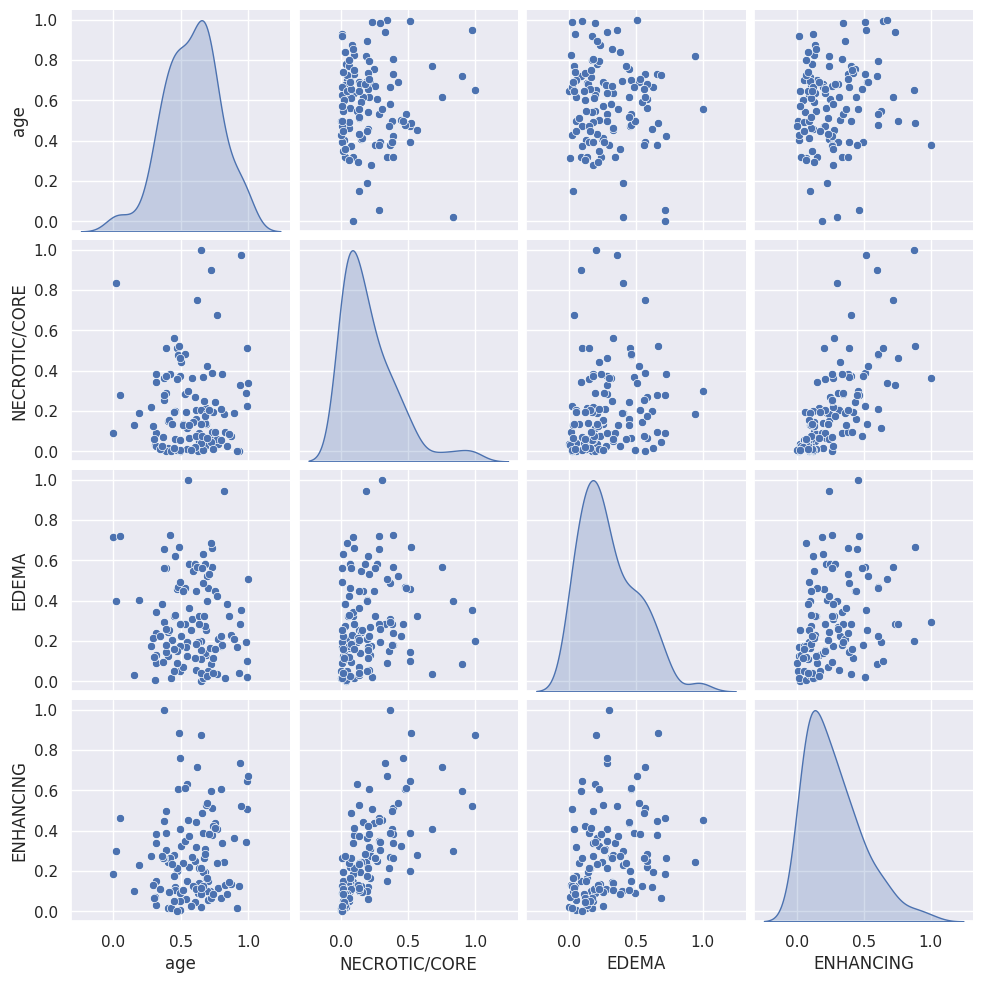

In [22]:
sns.set()

df = pd.DataFrame(X_all, columns = ["age", SEGMENT_CLASSES[1],SEGMENT_CLASSES[2],SEGMENT_CLASSES[3]])
sns.pairplot(df, diag_kind='kde')

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size = 0.2, random_state = 42, shuffle = True)

print("x_train shape:",X_train.shape)
print("x_test shape:", X_train.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (94, 4)
x_test shape: (94, 4)
y_train shape: (94, 3)
y_test shape: (24, 3)


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier(n_estimators=3, random_state=0)

# fit the model to the training set
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Model accuracy score with 3 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

accuracies = cross_val_score(rfc, X_train, y_train, cv=3)
# rfc.fit(X_train,y_train)

print("Cross validation: Train Score:",np.mean(accuracies))
print("Cross validation: Test Score:",rfc.score(X_test,y_test))

Model accuracy score with 3 decision-trees : 0.4583
Cross validation: Train Score: 0.2654569892473118
Cross validation: Test Score: 0.4583333333333333


In [26]:
df = pd.DataFrame(X_train, columns = ["age",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}"])

feature_scores = pd.Series(rfc.feature_importances_, index=df.columns).sort_values(ascending=False)
feature_scores

age              0.341641
EDEMA            0.240936
ENHANCING        0.227101
NECROTIC/CORE    0.190322
dtype: float64

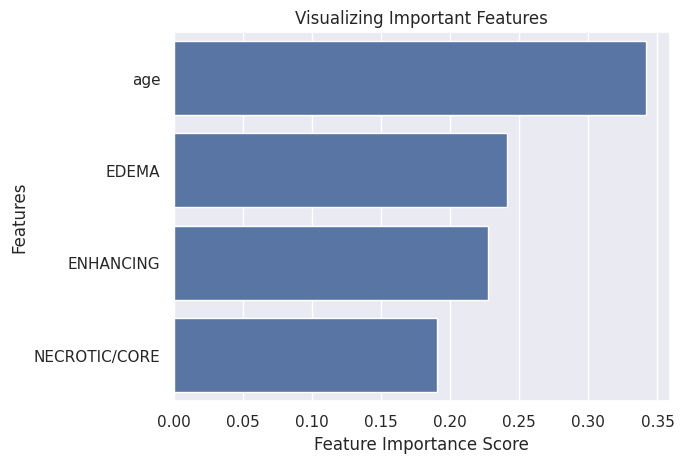

In [27]:
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

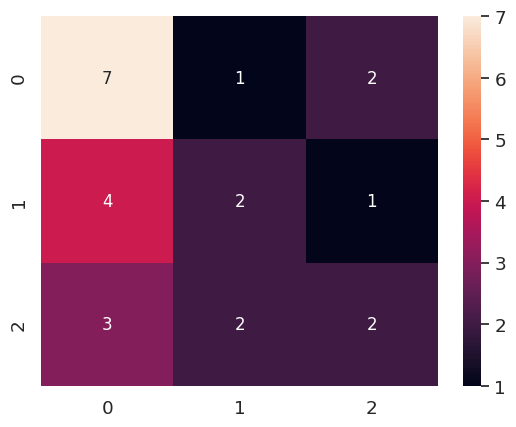

In [28]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, annot_kws={"size": 12})

plt.show()

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.40      0.29      0.33         7
           2       0.40      0.29      0.33         7

   micro avg       0.55      0.46      0.50        24
   macro avg       0.50      0.42      0.46        24
weighted avg       0.53      0.46      0.49        24
 samples avg       0.62      0.46      0.46        24



In [33]:
grid = {
    'n_estimators':np.arange(1,100,1),
    'criterion':['gini','entropy']
    }

rfc_ = RandomForestClassifier(random_state = 42)
rf_grid = GridSearchCV(rfc_, grid, cv=5)
rf_grid.fit(X_train,y_train)

print("Hyperparameters:",rf_grid.best_params_)
print("Train Score:", rf_grid.best_score_)
print("Test Score:",rf_grid.score(X_test,y_test))

Hyperparameters: {'criterion': 'entropy', 'n_estimators': 1}
Train Score: 0.3719298245614035
Test Score: 0.3333333333333333


In [34]:
from sklearn.svm import SVC

#convert one hot into multilabel
y_train_multi=np.argmax(y_train, axis=1)
y_test_multi =np.argmax(y_test, axis=1)

svc = SVC(random_state = 42, C=10, degree=3, gamma=1, kernel='poly')
svc.fit(X_train,y_train_multi)
accuracies = cross_val_score(svc, X_train, y_train_multi)

y_pred = svc.predict(X_test)

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test_multi, y_pred)))

print("Cross validation: Train Score:",np.mean(accuracies))
print("Cross validation: Test Score:",svc.score(X_test,y_test_multi))

Model accuracy score : 0.3333
Cross validation: Train Score: 0.41578947368421054
Cross validation: Test Score: 0.3333333333333333


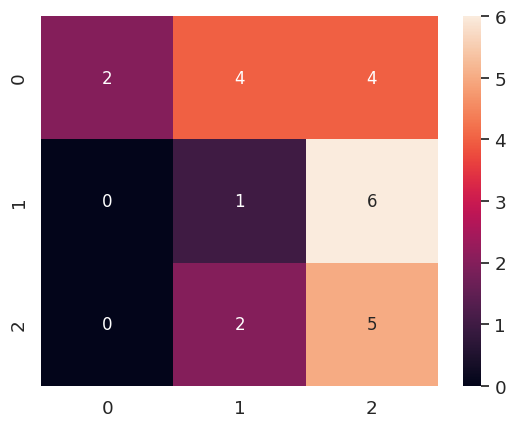

In [35]:
# convert to one hot
y_pred=y_pred.astype(int)
n_values = np.max(y_pred) + 1
y_pred_hot=np.eye(n_values)[y_pred]

cm = confusion_matrix(y_test.argmax(axis=1), y_pred_hot.argmax(axis=1))

sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, annot_kws={"size": 12})

plt.show()

In [36]:
print(classification_report(y_test_multi, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.20      0.33        10
           1       0.14      0.14      0.14         7
           2       0.33      0.71      0.45         7

    accuracy                           0.33        24
   macro avg       0.49      0.35      0.31        24
weighted avg       0.56      0.33      0.31        24



In [37]:
grid = {
    'C':[0.01,0.1,1,10,15,20],
    'kernel' : ["linear","poly","rbf","sigmoid"],
    'degree' : [1,3,5,7],
    'gamma' : [0.01,1]
}

svm  = SVC();
svm_grid = GridSearchCV(svm, grid, cv = 5)
svm_grid.fit(X_train,y_train_multi)
print("Best Parameters:",svm_grid.best_params_)
print("Train Score:",svm_grid.best_score_)
print("Test Score:",svm_grid.score(X_test,y_test_multi))

Best Parameters: {'C': 0.1, 'degree': 5, 'gamma': 1, 'kernel': 'poly'}
Train Score: 0.46842105263157896
Test Score: 0.2916666666666667


In [38]:
from sklearn.neighbors import KNeighborsClassifier

knn  = KNeighborsClassifier(n_neighbors=38, p=2, weights='distance')
knn.fit(X_train,y_train_multi)
accuracies = cross_val_score(knn, X_train, y_train_multi)

y_pred = knn.predict(X_test)

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test_multi, y_pred)))


print("Cross validation: Train Score:",np.mean(accuracies))
print("Cross validation: Test Score:",knn.score(X_test,y_test_multi))

Model accuracy score : 0.1667
Cross validation: Train Score: 0.3403508771929824
Cross validation: Test Score: 0.16666666666666666


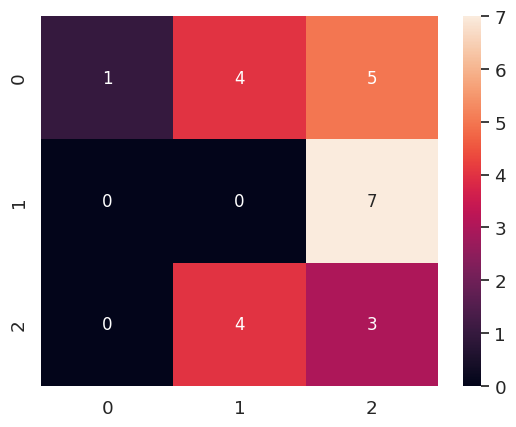

In [39]:
# convert to one hot
y_pred=y_pred.astype(int)
n_values = np.max(y_pred) + 1
y_pred_hot=np.eye(n_values)[y_pred]

cm = confusion_matrix(y_test.argmax(axis=1), y_pred_hot.argmax(axis=1))

sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, annot_kws={"size": 12})

plt.show()

In [40]:
print(classification_report(y_test_multi, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.00      0.00      0.00         7
           2       0.20      0.43      0.27         7

    accuracy                           0.17        24
   macro avg       0.40      0.18      0.15        24
weighted avg       0.48      0.17      0.16        24



In [41]:
grid = {
    'n_neighbors':np.arange(1,75),
    'p':np.arange(1,5),
    'weights':['uniform','distance']
    }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn,grid,cv=5)
knn_grid.fit(X_train,y_train_multi)

print("Hyperparameters:",knn_grid.best_params_)
print("Train Score:",knn_grid.best_score_)
print("Test Score:",knn_grid.score(X_test,y_test_multi))

Hyperparameters: {'n_neighbors': 6, 'p': 4, 'weights': 'distance'}
Train Score: 0.4807017543859649
Test Score: 0.3333333333333333


In [46]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(
    hidden_layer_sizes=11,
    max_iter=1000,
    alpha=1e-05,
    solver='lbfgs',
    verbose=10,
    random_state=6,
    tol=0.000000001
)

clf.fit(X_train, y_train_multi)
accuracies = cross_val_score(clf, X_train, y_train_multi)
y_pred = clf.predict(X_test)

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test_multi, y_pred)))
print("Cross validation: Train Score:",np.mean(accuracies))
print("Cross validation: Test Score:",clf.score(X_test,y_test_multi))

Model accuracy score : 0.5833
Cross validation: Train Score: 0.3292397660818713
Cross validation: Test Score: 0.5833333333333334


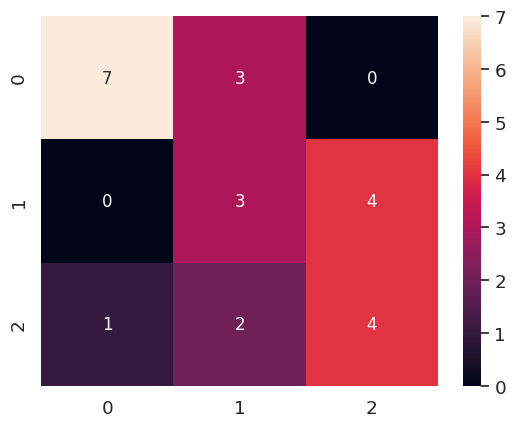

In [47]:
# convert to one hot
y_pred=y_pred.astype(int)
n_values = np.max(y_pred) + 1
y_pred_hot=np.eye(n_values)[y_pred]

cm = confusion_matrix(y_test.argmax(axis=1), y_pred_hot.argmax(axis=1))

sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, annot_kws={"size": 12})

plt.show()

In [48]:
grid = {
    'solver': ['lbfgs'],
    'max_iter': [25,50,100,150,200,300,500,1000 ],
    'alpha': 10.0 ** -np.arange(1, 10),
    'hidden_layer_sizes':np.arange(10, 15),
    'random_state':[0,1,2,3,4,5,6,7,8,9]
}
clf_grid = GridSearchCV(MLPClassifier(), grid, n_jobs=-1)

clf_grid.fit(X_train, y_train_multi)

print("Hyperparameters:",clf_grid.best_params_)
print("Train Score:",clf_grid.best_score_)
print("Test Score:",clf_grid.score(X_test, y_test_multi))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Hyperparameters: {'alpha': 0.1, 'hidden_layer_sizes': 12, 'max_iter': 200, 'random_state': 5, 'solver': 'lbfgs'}
Train Score: 0.4912280701754386
Test Score: 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
